In [24]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [25]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [26]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [27]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [28]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [29]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [30]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [31]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [32]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [33]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [34]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [35]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [36]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


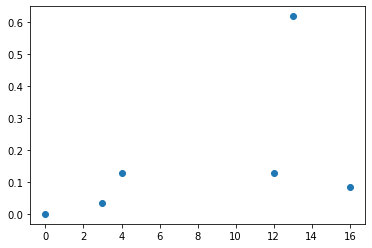

In [37]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [38]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [39]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [40]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [41]:
def R(i,theta):
    
    if i%7 == 0:
        return(ms_gate_global(theta))
    

    
    if i%7 == 1:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%7 == 2:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%7 == 3:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%7 == 4:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%7 == 5:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%7 == 6:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%7 == 0:
        return(-1j*matrix_part)

    
     
    if i%7 == 1:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%7 == 2:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%7 == 3:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%7 == 4:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%7 == 5:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%7 == 6:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [42]:
coeff = 7
stepp = 1000
t_final = 10

In [43]:
matr = full_ham_matrix.toarray()
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

In [44]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])
        
    psi_b = psi_0
    for k in range(coeff*N):
        psi_b = B[coeff*N-1-k]@psi_b
        
    psi_conj_b = np.conj(psi_b)

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        B[k] = S(k)@R(k,theta[k])
        psi_d[k] = psi_0
        for i in range(coeff*N):
            psi_d[k] = B[coeff*N-1-i]@psi_d[k]
        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    
    psi_conj_d = np.conj(psi_d)
    


    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)


    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [45]:
time_domain = np.linspace(0, t_final, stepp)


In [46]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [47]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-10 18:57:52.283899
start 2022-08-10 18:57:52.403077
stop_reduce 2022-08-10 18:57:52.641503
2022-08-10 18:57:52.642652
0
2022-08-10 18:57:52.642965
start 2022-08-10 18:57:52.737858
stop_reduce 2022-08-10 18:57:52.957079
2022-08-10 18:57:52.958052
0.005
2022-08-10 18:57:52.958377
start 2022-08-10 18:57:53.054579
stop_reduce 2022-08-10 18:57:53.274675
2022-08-10 18:57:53.275675
0.005
2022-08-10 18:57:53.275959
start 2022-08-10 18:57:53.373635
stop_reduce 2022-08-10 18:57:53.596971
2022-08-10 18:57:53.597852
0.01
2022-08-10 18:57:53.598147
start 2022-08-10 18:57:53.695397
stop_reduce 2022-08-10 18:57:53.937718
2022-08-10 18:57:53.938687
0.01
2022-08-10 18:57:53.938988
start 2022-08-10 18:57:54.036364
stop_reduce 2022-08-10 18:57:54.309404
2022-08-10 18:57:54.310305
0.015
2022-08-10 18:57:54.310591
start 2022-08-10 18:57:54.408999
stop_reduce 2022-08-10 18:57:54.631873
2022-08-10 18:57:54.632848
0.015
2022-08-10 18:57:54.633131
start 2022-08-10 18:57:54.736333
stop_reduce 2022-08-10

stop_reduce 2022-08-10 18:58:12.666045
2022-08-10 18:58:12.667059
0.15
2022-08-10 18:58:12.667358
start 2022-08-10 18:58:12.769173
stop_reduce 2022-08-10 18:58:12.994584
2022-08-10 18:58:12.995569
0.155
2022-08-10 18:58:12.995842
start 2022-08-10 18:58:13.092920
stop_reduce 2022-08-10 18:58:13.323787
2022-08-10 18:58:13.324735
0.155
2022-08-10 18:58:13.325018
start 2022-08-10 18:58:13.420811
stop_reduce 2022-08-10 18:58:13.665212
2022-08-10 18:58:13.666191
0.16
2022-08-10 18:58:13.666503
start 2022-08-10 18:58:13.765289
stop_reduce 2022-08-10 18:58:13.997190
2022-08-10 18:58:13.998142
0.16
2022-08-10 18:58:13.998435
start 2022-08-10 18:58:14.100194
stop_reduce 2022-08-10 18:58:14.329153
2022-08-10 18:58:14.330128
0.165
2022-08-10 18:58:14.330422
start 2022-08-10 18:58:14.425659
stop_reduce 2022-08-10 18:58:14.649435
2022-08-10 18:58:14.650431
0.165
2022-08-10 18:58:14.650699
start 2022-08-10 18:58:14.747019
stop_reduce 2022-08-10 18:58:14.972041
2022-08-10 18:58:14.973024
0.17
2022-08-

stop_reduce 2022-08-10 18:58:31.408534
2022-08-10 18:58:31.409500
0.2950000000000001
2022-08-10 18:58:31.409791
start 2022-08-10 18:58:31.506195
stop_reduce 2022-08-10 18:58:31.724812
2022-08-10 18:58:31.725781
0.3000000000000001
2022-08-10 18:58:31.726077
start 2022-08-10 18:58:31.821194
stop_reduce 2022-08-10 18:58:32.039102
2022-08-10 18:58:32.040018
0.3000000000000001
2022-08-10 18:58:32.040293
start 2022-08-10 18:58:32.135405
stop_reduce 2022-08-10 18:58:32.353200
2022-08-10 18:58:32.354160
0.3050000000000001
2022-08-10 18:58:32.354443
start 2022-08-10 18:58:32.449616
stop_reduce 2022-08-10 18:58:32.666017
2022-08-10 18:58:32.666990
0.3050000000000001
2022-08-10 18:58:32.667286
start 2022-08-10 18:58:32.762054
stop_reduce 2022-08-10 18:58:32.979473
2022-08-10 18:58:32.980338
0.3100000000000001
2022-08-10 18:58:32.980629
start 2022-08-10 18:58:33.075288
stop_reduce 2022-08-10 18:58:33.293151
2022-08-10 18:58:33.294134
0.3100000000000001
2022-08-10 18:58:33.294430
start 2022-08-10 1

stop_reduce 2022-08-10 18:58:51.985697
2022-08-10 18:58:51.986872
0.4400000000000002
2022-08-10 18:58:51.987301
start 2022-08-10 18:58:52.131093
stop_reduce 2022-08-10 18:58:52.452791
2022-08-10 18:58:52.453943
0.4400000000000002
2022-08-10 18:58:52.454319
start 2022-08-10 18:58:52.610376
stop_reduce 2022-08-10 18:58:52.952367
2022-08-10 18:58:52.953720
0.44500000000000023
2022-08-10 18:58:52.954136
start 2022-08-10 18:58:53.101770
stop_reduce 2022-08-10 18:58:53.502997
2022-08-10 18:58:53.504240
0.44500000000000023
2022-08-10 18:58:53.504605
start 2022-08-10 18:58:53.645337
stop_reduce 2022-08-10 18:58:53.986070
2022-08-10 18:58:53.987305
0.45000000000000023
2022-08-10 18:58:53.987723
start 2022-08-10 18:58:54.130527
stop_reduce 2022-08-10 18:58:54.451057
2022-08-10 18:58:54.452153
0.45000000000000023
2022-08-10 18:58:54.452537
start 2022-08-10 18:58:54.598484
stop_reduce 2022-08-10 18:58:54.923124
2022-08-10 18:58:54.924356
0.45500000000000024
2022-08-10 18:58:54.924780
start 2022-08

stop_reduce 2022-08-10 18:59:14.597111
2022-08-10 18:59:14.598009
0.5800000000000003
2022-08-10 18:59:14.598293
start 2022-08-10 18:59:14.702174
stop_reduce 2022-08-10 18:59:14.936598
2022-08-10 18:59:14.937631
0.5850000000000003
2022-08-10 18:59:14.937924
start 2022-08-10 18:59:15.041741
stop_reduce 2022-08-10 18:59:15.291548
2022-08-10 18:59:15.292451
0.5850000000000003
2022-08-10 18:59:15.292729
start 2022-08-10 18:59:15.388926
stop_reduce 2022-08-10 18:59:15.635825
2022-08-10 18:59:15.636743
0.5900000000000003
2022-08-10 18:59:15.637408
start 2022-08-10 18:59:15.762215
stop_reduce 2022-08-10 18:59:15.995593
2022-08-10 18:59:15.996511
0.5900000000000003
2022-08-10 18:59:15.996800
start 2022-08-10 18:59:16.103732
stop_reduce 2022-08-10 18:59:16.358684
2022-08-10 18:59:16.359724
0.5950000000000003
2022-08-10 18:59:16.360042
start 2022-08-10 18:59:16.459049
stop_reduce 2022-08-10 18:59:16.725759
2022-08-10 18:59:16.726819
0.5950000000000003
2022-08-10 18:59:16.727110
start 2022-08-10 1

stop_reduce 2022-08-10 18:59:33.334393
2022-08-10 18:59:33.335365
0.7250000000000004
2022-08-10 18:59:33.335648
start 2022-08-10 18:59:33.432543
stop_reduce 2022-08-10 18:59:33.651909
2022-08-10 18:59:33.652859
0.7250000000000004
2022-08-10 18:59:33.653138
start 2022-08-10 18:59:33.750105
stop_reduce 2022-08-10 18:59:33.970609
2022-08-10 18:59:33.971583
0.7300000000000004
2022-08-10 18:59:33.971877
start 2022-08-10 18:59:34.068976
stop_reduce 2022-08-10 18:59:34.289032
2022-08-10 18:59:34.289932
0.7300000000000004
2022-08-10 18:59:34.290220
start 2022-08-10 18:59:34.388076
stop_reduce 2022-08-10 18:59:34.607322
2022-08-10 18:59:34.608264
0.7350000000000004
2022-08-10 18:59:34.608577
start 2022-08-10 18:59:34.705736
stop_reduce 2022-08-10 18:59:34.925758
2022-08-10 18:59:34.926739
0.7350000000000004
2022-08-10 18:59:34.927030
start 2022-08-10 18:59:35.024477
stop_reduce 2022-08-10 18:59:35.245931
2022-08-10 18:59:35.246907
0.7400000000000004
2022-08-10 18:59:35.247218
start 2022-08-10 1

stop_reduce 2022-08-10 18:59:53.168363
2022-08-10 18:59:53.169303
0.8650000000000005
2022-08-10 18:59:53.169604
start 2022-08-10 18:59:53.274273
stop_reduce 2022-08-10 18:59:53.539805
2022-08-10 18:59:53.540799
0.8700000000000006
2022-08-10 18:59:53.541090
start 2022-08-10 18:59:53.641493
stop_reduce 2022-08-10 18:59:53.870520
2022-08-10 18:59:53.871535
0.8700000000000006
2022-08-10 18:59:53.871840
start 2022-08-10 18:59:53.977979
stop_reduce 2022-08-10 18:59:54.211225
2022-08-10 18:59:54.212229
0.8750000000000006
2022-08-10 18:59:54.212519
start 2022-08-10 18:59:54.312909
stop_reduce 2022-08-10 18:59:54.580726
2022-08-10 18:59:54.581661
0.8750000000000006
2022-08-10 18:59:54.581966
start 2022-08-10 18:59:54.717987
stop_reduce 2022-08-10 18:59:55.004028
2022-08-10 18:59:55.005004
0.8800000000000006
2022-08-10 18:59:55.005304
start 2022-08-10 18:59:55.105584
stop_reduce 2022-08-10 18:59:55.364066
2022-08-10 18:59:55.364953
0.8800000000000006
2022-08-10 18:59:55.365236
start 2022-08-10 1

stop_reduce 2022-08-10 19:00:12.370160
2022-08-10 19:00:12.371200
1.0100000000000007
2022-08-10 19:00:12.371514
start 2022-08-10 19:00:12.473991
stop_reduce 2022-08-10 19:00:12.726320
2022-08-10 19:00:12.727337
1.0100000000000007
2022-08-10 19:00:12.727660
start 2022-08-10 19:00:12.834187
stop_reduce 2022-08-10 19:00:13.064432
2022-08-10 19:00:13.065361
1.0150000000000006
2022-08-10 19:00:13.065647
start 2022-08-10 19:00:13.171974
stop_reduce 2022-08-10 19:00:13.433883
2022-08-10 19:00:13.434754
1.0150000000000006
2022-08-10 19:00:13.435026
start 2022-08-10 19:00:13.535358
stop_reduce 2022-08-10 19:00:13.761155
2022-08-10 19:00:13.761989
1.0200000000000007
2022-08-10 19:00:13.762241
start 2022-08-10 19:00:13.866603
stop_reduce 2022-08-10 19:00:14.096612
2022-08-10 19:00:14.097570
1.0200000000000007
2022-08-10 19:00:14.097850
start 2022-08-10 19:00:14.199717
stop_reduce 2022-08-10 19:00:14.427602
2022-08-10 19:00:14.428465
1.0250000000000006
2022-08-10 19:00:14.428728
start 2022-08-10 1

stop_reduce 2022-08-10 19:00:31.367302
2022-08-10 19:00:31.368191
1.1500000000000008
2022-08-10 19:00:31.368475
start 2022-08-10 19:00:31.469724
stop_reduce 2022-08-10 19:00:31.711102
2022-08-10 19:00:31.712016
1.1550000000000007
2022-08-10 19:00:31.712301
start 2022-08-10 19:00:31.834460
stop_reduce 2022-08-10 19:00:32.071089
2022-08-10 19:00:32.072027
1.1550000000000007
2022-08-10 19:00:32.072298
start 2022-08-10 19:00:32.175280
stop_reduce 2022-08-10 19:00:32.409203
2022-08-10 19:00:32.410117
1.1600000000000008
2022-08-10 19:00:32.410387
start 2022-08-10 19:00:32.512031
stop_reduce 2022-08-10 19:00:32.745599
2022-08-10 19:00:32.746578
1.1600000000000008
2022-08-10 19:00:32.746874
start 2022-08-10 19:00:32.858038
stop_reduce 2022-08-10 19:00:33.088741
2022-08-10 19:00:33.089633
1.1650000000000007
2022-08-10 19:00:33.089904
start 2022-08-10 19:00:33.192729
stop_reduce 2022-08-10 19:00:33.421861
2022-08-10 19:00:33.422803
1.1650000000000007
2022-08-10 19:00:33.423069
start 2022-08-10 1

stop_reduce 2022-08-10 19:00:51.197806
2022-08-10 19:00:51.198705
1.2950000000000008
2022-08-10 19:00:51.198979
start 2022-08-10 19:00:51.299911
stop_reduce 2022-08-10 19:00:51.529763
2022-08-10 19:00:51.530735
1.2950000000000008
2022-08-10 19:00:51.531018
start 2022-08-10 19:00:51.632030
stop_reduce 2022-08-10 19:00:51.861126
2022-08-10 19:00:51.861968
1.300000000000001
2022-08-10 19:00:51.862231
start 2022-08-10 19:00:51.966534
stop_reduce 2022-08-10 19:00:52.194406
2022-08-10 19:00:52.195268
1.300000000000001
2022-08-10 19:00:52.195529
start 2022-08-10 19:00:52.296661
stop_reduce 2022-08-10 19:00:52.528238
2022-08-10 19:00:52.529151
1.3050000000000008
2022-08-10 19:00:52.529426
start 2022-08-10 19:00:52.630684
stop_reduce 2022-08-10 19:00:52.857478
2022-08-10 19:00:52.858297
1.3050000000000008
2022-08-10 19:00:52.858542
start 2022-08-10 19:00:52.964429
stop_reduce 2022-08-10 19:00:53.192942
2022-08-10 19:00:53.193867
1.310000000000001
2022-08-10 19:00:53.194152
start 2022-08-10 19:0

stop_reduce 2022-08-10 19:01:10.135733
2022-08-10 19:01:10.136663
1.435000000000001
2022-08-10 19:01:10.136945
start 2022-08-10 19:01:10.238459
stop_reduce 2022-08-10 19:01:10.468654
2022-08-10 19:01:10.469582
1.440000000000001
2022-08-10 19:01:10.469864
start 2022-08-10 19:01:10.570772
stop_reduce 2022-08-10 19:01:10.799849
2022-08-10 19:01:10.800709
1.440000000000001
2022-08-10 19:01:10.800960
start 2022-08-10 19:01:10.901868
stop_reduce 2022-08-10 19:01:11.132428
2022-08-10 19:01:11.133265
1.445000000000001
2022-08-10 19:01:11.133531
start 2022-08-10 19:01:11.234404
stop_reduce 2022-08-10 19:01:11.463697
2022-08-10 19:01:11.464603
1.445000000000001
2022-08-10 19:01:11.464857
start 2022-08-10 19:01:11.566328
stop_reduce 2022-08-10 19:01:11.793641
2022-08-10 19:01:11.794455
1.450000000000001
2022-08-10 19:01:11.794708
start 2022-08-10 19:01:11.897103
stop_reduce 2022-08-10 19:01:12.126845
2022-08-10 19:01:12.127753
1.450000000000001
2022-08-10 19:01:12.128019
start 2022-08-10 19:01:12

stop_reduce 2022-08-10 19:01:29.094740
2022-08-10 19:01:29.095680
1.5800000000000012
2022-08-10 19:01:29.095982
start 2022-08-10 19:01:29.200155
stop_reduce 2022-08-10 19:01:29.430607
2022-08-10 19:01:29.431532
1.5800000000000012
2022-08-10 19:01:29.431798
start 2022-08-10 19:01:29.533776
stop_reduce 2022-08-10 19:01:29.768160
2022-08-10 19:01:29.769039
1.585000000000001
2022-08-10 19:01:29.769311
start 2022-08-10 19:01:29.881542
stop_reduce 2022-08-10 19:01:30.187762
2022-08-10 19:01:30.188760
1.585000000000001
2022-08-10 19:01:30.189055
start 2022-08-10 19:01:30.291239
stop_reduce 2022-08-10 19:01:30.522809
2022-08-10 19:01:30.523756
1.5900000000000012
2022-08-10 19:01:30.524055
start 2022-08-10 19:01:30.627315
stop_reduce 2022-08-10 19:01:30.869724
2022-08-10 19:01:30.870742
1.5900000000000012
2022-08-10 19:01:30.871055
start 2022-08-10 19:01:31.023515
stop_reduce 2022-08-10 19:01:31.304365
2022-08-10 19:01:31.305325
1.595000000000001
2022-08-10 19:01:31.305607
start 2022-08-10 19:0

stop_reduce 2022-08-10 19:01:49.020339
2022-08-10 19:01:49.021350
1.7200000000000013
2022-08-10 19:01:49.021627
start 2022-08-10 19:01:49.123817
stop_reduce 2022-08-10 19:01:49.353817
2022-08-10 19:01:49.354635
1.7250000000000012
2022-08-10 19:01:49.354880
start 2022-08-10 19:01:49.457158
stop_reduce 2022-08-10 19:01:49.689867
2022-08-10 19:01:49.690860
1.7250000000000012
2022-08-10 19:01:49.691141
start 2022-08-10 19:01:49.793130
stop_reduce 2022-08-10 19:01:50.023905
2022-08-10 19:01:50.024741
1.7300000000000013
2022-08-10 19:01:50.025017
start 2022-08-10 19:01:50.127321
stop_reduce 2022-08-10 19:01:50.368166
2022-08-10 19:01:50.369109
1.7300000000000013
2022-08-10 19:01:50.369390
start 2022-08-10 19:01:50.471644
stop_reduce 2022-08-10 19:01:50.701390
2022-08-10 19:01:50.702203
1.7350000000000012
2022-08-10 19:01:50.702459
start 2022-08-10 19:01:50.809549
stop_reduce 2022-08-10 19:01:51.040097
2022-08-10 19:01:51.040967
1.7350000000000012
2022-08-10 19:01:51.041215
start 2022-08-10 1

stop_reduce 2022-08-10 19:02:08.508126
2022-08-10 19:02:08.508938
1.8650000000000013
2022-08-10 19:02:08.509174
start 2022-08-10 19:02:08.610869
stop_reduce 2022-08-10 19:02:08.843737
2022-08-10 19:02:08.844708
1.8650000000000013
2022-08-10 19:02:08.844977
start 2022-08-10 19:02:08.946988
stop_reduce 2022-08-10 19:02:09.178615
2022-08-10 19:02:09.179457
1.8700000000000014
2022-08-10 19:02:09.179712
start 2022-08-10 19:02:09.283624
stop_reduce 2022-08-10 19:02:09.514122
2022-08-10 19:02:09.515037
1.8700000000000014
2022-08-10 19:02:09.515299
start 2022-08-10 19:02:09.616724
stop_reduce 2022-08-10 19:02:09.846872
2022-08-10 19:02:09.847677
1.8750000000000013
2022-08-10 19:02:09.847926
start 2022-08-10 19:02:09.962078
stop_reduce 2022-08-10 19:02:10.193741
2022-08-10 19:02:10.194618
1.8750000000000013
2022-08-10 19:02:10.194893
start 2022-08-10 19:02:10.296515
stop_reduce 2022-08-10 19:02:10.537775
2022-08-10 19:02:10.538735
1.8800000000000014
2022-08-10 19:02:10.539034
start 2022-08-10 1

stop_reduce 2022-08-10 19:02:27.934448
2022-08-10 19:02:27.935245
2.0050000000000012
2022-08-10 19:02:27.935487
start 2022-08-10 19:02:28.036775
stop_reduce 2022-08-10 19:02:28.278878
2022-08-10 19:02:28.279854
2.010000000000001
2022-08-10 19:02:28.280163
start 2022-08-10 19:02:28.381715
stop_reduce 2022-08-10 19:02:28.611247
2022-08-10 19:02:28.612062
2.010000000000001
2022-08-10 19:02:28.612316
start 2022-08-10 19:02:28.713288
stop_reduce 2022-08-10 19:02:28.955062
2022-08-10 19:02:28.956003
2.015000000000001
2022-08-10 19:02:28.956277
start 2022-08-10 19:02:29.057593
stop_reduce 2022-08-10 19:02:29.285872
2022-08-10 19:02:29.286686
2.015000000000001
2022-08-10 19:02:29.286941
start 2022-08-10 19:02:29.399387
stop_reduce 2022-08-10 19:02:29.628470
2022-08-10 19:02:29.629376
2.020000000000001
2022-08-10 19:02:29.629653
start 2022-08-10 19:02:29.731095
stop_reduce 2022-08-10 19:02:29.968944
2022-08-10 19:02:29.969987
2.020000000000001
2022-08-10 19:02:29.970270
start 2022-08-10 19:02:3

stop_reduce 2022-08-10 19:02:49.747713
2022-08-10 19:02:49.748611
2.149999999999998
2022-08-10 19:02:49.748871
start 2022-08-10 19:02:49.851006
stop_reduce 2022-08-10 19:02:50.079364
2022-08-10 19:02:50.080316
2.154999999999998
2022-08-10 19:02:50.080617
start 2022-08-10 19:02:50.182538
stop_reduce 2022-08-10 19:02:50.409717
2022-08-10 19:02:50.410591
2.154999999999998
2022-08-10 19:02:50.410844
start 2022-08-10 19:02:50.512738
stop_reduce 2022-08-10 19:02:50.742060
2022-08-10 19:02:50.743012
2.159999999999998
2022-08-10 19:02:50.743300
start 2022-08-10 19:02:50.845159
stop_reduce 2022-08-10 19:02:51.072474
2022-08-10 19:02:51.073269
2.159999999999998
2022-08-10 19:02:51.073513
start 2022-08-10 19:02:51.175571
stop_reduce 2022-08-10 19:02:51.406873
2022-08-10 19:02:51.407800
2.164999999999998
2022-08-10 19:02:51.408074
start 2022-08-10 19:02:51.510530
stop_reduce 2022-08-10 19:02:51.737832
2022-08-10 19:02:51.738651
2.164999999999998
2022-08-10 19:02:51.738906
start 2022-08-10 19:02:51

stop_reduce 2022-08-10 19:03:08.720486
2022-08-10 19:03:08.721440
2.294999999999995
2022-08-10 19:03:08.721728
start 2022-08-10 19:03:08.824034
stop_reduce 2022-08-10 19:03:09.052113
2022-08-10 19:03:09.052906
2.294999999999995
2022-08-10 19:03:09.053143
start 2022-08-10 19:03:09.155454
stop_reduce 2022-08-10 19:03:09.387707
2022-08-10 19:03:09.388676
2.299999999999995
2022-08-10 19:03:09.388973
start 2022-08-10 19:03:09.491485
stop_reduce 2022-08-10 19:03:09.719469
2022-08-10 19:03:09.720278
2.299999999999995
2022-08-10 19:03:09.720510
start 2022-08-10 19:03:09.826629
stop_reduce 2022-08-10 19:03:10.055056
2022-08-10 19:03:10.055937
2.304999999999995
2022-08-10 19:03:10.056198
start 2022-08-10 19:03:10.158202
stop_reduce 2022-08-10 19:03:10.387998
2022-08-10 19:03:10.388818
2.304999999999995
2022-08-10 19:03:10.389078
start 2022-08-10 19:03:10.491396
stop_reduce 2022-08-10 19:03:10.719108
2022-08-10 19:03:10.719959
2.3099999999999947
2022-08-10 19:03:10.720216
start 2022-08-10 19:03:1

stop_reduce 2022-08-10 19:03:28.372416
2022-08-10 19:03:28.373360
2.434999999999992
2022-08-10 19:03:28.373630
start 2022-08-10 19:03:28.475228
stop_reduce 2022-08-10 19:03:28.702233
2022-08-10 19:03:28.703024
2.439999999999992
2022-08-10 19:03:28.703259
start 2022-08-10 19:03:28.805736
stop_reduce 2022-08-10 19:03:29.041823
2022-08-10 19:03:29.042689
2.439999999999992
2022-08-10 19:03:29.042960
start 2022-08-10 19:03:29.149821
stop_reduce 2022-08-10 19:03:29.389572
2022-08-10 19:03:29.390512
2.444999999999992
2022-08-10 19:03:29.390796
start 2022-08-10 19:03:29.494896
stop_reduce 2022-08-10 19:03:29.731269
2022-08-10 19:03:29.732169
2.444999999999992
2022-08-10 19:03:29.732429
start 2022-08-10 19:03:29.836586
stop_reduce 2022-08-10 19:03:30.114352
2022-08-10 19:03:30.115249
2.4499999999999917
2022-08-10 19:03:30.115527
start 2022-08-10 19:03:30.229389
stop_reduce 2022-08-10 19:03:30.566021
2022-08-10 19:03:30.567068
2.4499999999999917
2022-08-10 19:03:30.567482
start 2022-08-10 19:03:

stop_reduce 2022-08-10 19:03:47.519496
2022-08-10 19:03:47.520299
2.579999999999989
2022-08-10 19:03:47.520549
start 2022-08-10 19:03:47.622407
stop_reduce 2022-08-10 19:03:47.850711
2022-08-10 19:03:47.851522
2.579999999999989
2022-08-10 19:03:47.851782
start 2022-08-10 19:03:47.953154
stop_reduce 2022-08-10 19:03:48.179933
2022-08-10 19:03:48.180803
2.584999999999989
2022-08-10 19:03:48.181063
start 2022-08-10 19:03:48.282781
stop_reduce 2022-08-10 19:03:48.510116
2022-08-10 19:03:48.510943
2.584999999999989
2022-08-10 19:03:48.511188
start 2022-08-10 19:03:48.612727
stop_reduce 2022-08-10 19:03:48.839431
2022-08-10 19:03:48.840207
2.5899999999999888
2022-08-10 19:03:48.840456
start 2022-08-10 19:03:48.941965
stop_reduce 2022-08-10 19:03:49.170186
2022-08-10 19:03:49.171008
2.5899999999999888
2022-08-10 19:03:49.171265
start 2022-08-10 19:03:49.272823
stop_reduce 2022-08-10 19:03:49.499739
2022-08-10 19:03:49.500514
2.5949999999999886
2022-08-10 19:03:49.500749
start 2022-08-10 19:03

stop_reduce 2022-08-10 19:04:06.262380
2022-08-10 19:04:06.263185
2.719999999999986
2022-08-10 19:04:06.263428
start 2022-08-10 19:04:06.363762
stop_reduce 2022-08-10 19:04:06.587545
2022-08-10 19:04:06.588304
2.724999999999986
2022-08-10 19:04:06.588533
start 2022-08-10 19:04:06.689444
stop_reduce 2022-08-10 19:04:06.913183
2022-08-10 19:04:06.913979
2.724999999999986
2022-08-10 19:04:06.914219
start 2022-08-10 19:04:07.014350
stop_reduce 2022-08-10 19:04:07.238341
2022-08-10 19:04:07.239130
2.7299999999999858
2022-08-10 19:04:07.239382
start 2022-08-10 19:04:07.339534
stop_reduce 2022-08-10 19:04:07.563531
2022-08-10 19:04:07.564263
2.7299999999999858
2022-08-10 19:04:07.564503
start 2022-08-10 19:04:07.665001
stop_reduce 2022-08-10 19:04:07.888888
2022-08-10 19:04:07.889684
2.7349999999999857
2022-08-10 19:04:07.889941
start 2022-08-10 19:04:07.990142
stop_reduce 2022-08-10 19:04:08.213940
2022-08-10 19:04:08.214687
2.7349999999999857
2022-08-10 19:04:08.214938
start 2022-08-10 19:0

stop_reduce 2022-08-10 19:04:24.434621
2022-08-10 19:04:24.435239
2.864999999999983
2022-08-10 19:04:24.435411
start 2022-08-10 19:04:24.507323
stop_reduce 2022-08-10 19:04:24.677114
2022-08-10 19:04:24.677826
2.864999999999983
2022-08-10 19:04:24.678014
start 2022-08-10 19:04:24.751642
stop_reduce 2022-08-10 19:04:24.914194
2022-08-10 19:04:24.914798
2.869999999999983
2022-08-10 19:04:24.914976
start 2022-08-10 19:04:24.988854
stop_reduce 2022-08-10 19:04:25.153297
2022-08-10 19:04:25.154020
2.869999999999983
2022-08-10 19:04:25.154237
start 2022-08-10 19:04:25.233962
stop_reduce 2022-08-10 19:04:25.396492
2022-08-10 19:04:25.397103
2.8749999999999827
2022-08-10 19:04:25.397289
start 2022-08-10 19:04:25.474946
stop_reduce 2022-08-10 19:04:25.639242
2022-08-10 19:04:25.639883
2.8749999999999827
2022-08-10 19:04:25.640061
start 2022-08-10 19:04:25.712324
stop_reduce 2022-08-10 19:04:25.882251
2022-08-10 19:04:25.883008
2.8799999999999826
2022-08-10 19:04:25.883236
start 2022-08-10 19:04

stop_reduce 2022-08-10 19:04:42.689037
2022-08-10 19:04:42.689940
3.00499999999998
2022-08-10 19:04:42.690199
start 2022-08-10 19:04:42.790704
stop_reduce 2022-08-10 19:04:43.015435
2022-08-10 19:04:43.016324
3.00999999999998
2022-08-10 19:04:43.016613
start 2022-08-10 19:04:43.118173
stop_reduce 2022-08-10 19:04:43.343911
2022-08-10 19:04:43.344857
3.00999999999998
2022-08-10 19:04:43.345137
start 2022-08-10 19:04:43.445919
stop_reduce 2022-08-10 19:04:43.671922
2022-08-10 19:04:43.672856
3.0149999999999797
2022-08-10 19:04:43.673144
start 2022-08-10 19:04:43.773695
stop_reduce 2022-08-10 19:04:43.998962
2022-08-10 19:04:43.999791
3.0149999999999797
2022-08-10 19:04:44.000023
start 2022-08-10 19:04:44.100589
stop_reduce 2022-08-10 19:04:44.334753
2022-08-10 19:04:44.335727
3.0199999999999796
2022-08-10 19:04:44.336030
start 2022-08-10 19:04:44.436392
stop_reduce 2022-08-10 19:04:44.661284
2022-08-10 19:04:44.662069
3.0199999999999796
2022-08-10 19:04:44.662305
start 2022-08-10 19:04:4

stop_reduce 2022-08-10 19:05:01.429275
2022-08-10 19:05:01.430143
3.149999999999977
2022-08-10 19:05:01.430430
start 2022-08-10 19:05:01.531463
stop_reduce 2022-08-10 19:05:01.768383
2022-08-10 19:05:01.769317
3.149999999999977
2022-08-10 19:05:01.769600
start 2022-08-10 19:05:01.870396
stop_reduce 2022-08-10 19:05:02.094746
2022-08-10 19:05:02.095514
3.1549999999999767
2022-08-10 19:05:02.095744
start 2022-08-10 19:05:02.196524
stop_reduce 2022-08-10 19:05:02.422871
2022-08-10 19:05:02.423808
3.1549999999999767
2022-08-10 19:05:02.424078
start 2022-08-10 19:05:02.529852
stop_reduce 2022-08-10 19:05:02.756616
2022-08-10 19:05:02.757482
3.1599999999999766
2022-08-10 19:05:02.757757
start 2022-08-10 19:05:02.859454
stop_reduce 2022-08-10 19:05:03.085105
2022-08-10 19:05:03.086008
3.1599999999999766
2022-08-10 19:05:03.086277
start 2022-08-10 19:05:03.187073
stop_reduce 2022-08-10 19:05:03.414249
2022-08-10 19:05:03.415120
3.1649999999999765
2022-08-10 19:05:03.415394
start 2022-08-10 19:

stop_reduce 2022-08-10 19:05:20.162810
2022-08-10 19:05:20.163805
3.289999999999974
2022-08-10 19:05:20.164115
start 2022-08-10 19:05:20.265152
stop_reduce 2022-08-10 19:05:20.490467
2022-08-10 19:05:20.491278
3.2949999999999737
2022-08-10 19:05:20.491529
start 2022-08-10 19:05:20.592141
stop_reduce 2022-08-10 19:05:20.818346
2022-08-10 19:05:20.819290
3.2949999999999737
2022-08-10 19:05:20.819579
start 2022-08-10 19:05:20.920131
stop_reduce 2022-08-10 19:05:21.148118
2022-08-10 19:05:21.148954
3.2999999999999736
2022-08-10 19:05:21.149218
start 2022-08-10 19:05:21.250933
stop_reduce 2022-08-10 19:05:21.475822
2022-08-10 19:05:21.476724
3.2999999999999736
2022-08-10 19:05:21.476997
start 2022-08-10 19:05:21.577646
stop_reduce 2022-08-10 19:05:21.803188
2022-08-10 19:05:21.803994
3.3049999999999735
2022-08-10 19:05:21.804236
start 2022-08-10 19:05:21.905857
stop_reduce 2022-08-10 19:05:22.130972
2022-08-10 19:05:22.131891
3.3049999999999735
2022-08-10 19:05:22.132161
start 2022-08-10 19

stop_reduce 2022-08-10 19:05:36.203957
2022-08-10 19:05:36.204829
3.4349999999999707
2022-08-10 19:05:36.205081
start 2022-08-10 19:05:36.306603
stop_reduce 2022-08-10 19:05:36.531592
2022-08-10 19:05:36.532480
3.4349999999999707
2022-08-10 19:05:36.532732
start 2022-08-10 19:05:36.633245
stop_reduce 2022-08-10 19:05:36.858277
2022-08-10 19:05:36.859059
3.4399999999999706
2022-08-10 19:05:36.859312
start 2022-08-10 19:05:36.960783
stop_reduce 2022-08-10 19:05:37.186844
2022-08-10 19:05:37.187721
3.4399999999999706
2022-08-10 19:05:37.187985
start 2022-08-10 19:05:37.288714
stop_reduce 2022-08-10 19:05:37.514310
2022-08-10 19:05:37.515291
3.4449999999999705
2022-08-10 19:05:37.515561
start 2022-08-10 19:05:37.616100
stop_reduce 2022-08-10 19:05:37.840628
2022-08-10 19:05:37.841464
3.4449999999999705
2022-08-10 19:05:37.841706
start 2022-08-10 19:05:37.942811
stop_reduce 2022-08-10 19:05:38.174611
2022-08-10 19:05:38.175612
3.4499999999999704
2022-08-10 19:05:38.175917
start 2022-08-10 1

stop_reduce 2022-08-10 19:05:55.778893
2022-08-10 19:05:55.779823
3.5749999999999678
2022-08-10 19:05:55.780087
start 2022-08-10 19:05:55.916938
stop_reduce 2022-08-10 19:05:56.168645
2022-08-10 19:05:56.169585
3.5799999999999677
2022-08-10 19:05:56.169900
start 2022-08-10 19:05:56.287994
stop_reduce 2022-08-10 19:05:56.529909
2022-08-10 19:05:56.531121
3.5799999999999677
2022-08-10 19:05:56.531427
start 2022-08-10 19:05:56.637983
stop_reduce 2022-08-10 19:05:56.879412
2022-08-10 19:05:56.880345
3.5849999999999675
2022-08-10 19:05:56.880613
start 2022-08-10 19:05:56.982952
stop_reduce 2022-08-10 19:05:57.223692
2022-08-10 19:05:57.224672
3.5849999999999675
2022-08-10 19:05:57.224965
start 2022-08-10 19:05:57.327825
stop_reduce 2022-08-10 19:05:57.570621
2022-08-10 19:05:57.571614
3.5899999999999674
2022-08-10 19:05:57.571912
start 2022-08-10 19:05:57.683160
stop_reduce 2022-08-10 19:05:57.942226
2022-08-10 19:05:57.943212
3.5899999999999674
2022-08-10 19:05:57.943498
start 2022-08-10 1

stop_reduce 2022-08-10 19:06:15.270580
2022-08-10 19:06:15.271534
3.7199999999999647
2022-08-10 19:06:15.271821
start 2022-08-10 19:06:15.375934
stop_reduce 2022-08-10 19:06:15.607551
2022-08-10 19:06:15.608511
3.7199999999999647
2022-08-10 19:06:15.608816
start 2022-08-10 19:06:15.712541
stop_reduce 2022-08-10 19:06:15.944226
2022-08-10 19:06:15.945198
3.7249999999999646
2022-08-10 19:06:15.945477
start 2022-08-10 19:06:16.048996
stop_reduce 2022-08-10 19:06:16.280820
2022-08-10 19:06:16.281720
3.7249999999999646
2022-08-10 19:06:16.282002
start 2022-08-10 19:06:16.386050
stop_reduce 2022-08-10 19:06:16.617799
2022-08-10 19:06:16.618773
3.7299999999999645
2022-08-10 19:06:16.619078
start 2022-08-10 19:06:16.722496
stop_reduce 2022-08-10 19:06:16.953910
2022-08-10 19:06:16.954829
3.7299999999999645
2022-08-10 19:06:16.955114
start 2022-08-10 19:06:17.058694
stop_reduce 2022-08-10 19:06:17.290281
2022-08-10 19:06:17.291224
3.7349999999999643
2022-08-10 19:06:17.291514
start 2022-08-10 1

stop_reduce 2022-08-10 19:06:35.679476
2022-08-10 19:06:35.680622
3.8599999999999617
2022-08-10 19:06:35.680926
start 2022-08-10 19:06:35.790806
stop_reduce 2022-08-10 19:06:36.032257
2022-08-10 19:06:36.033196
3.8649999999999616
2022-08-10 19:06:36.033488
start 2022-08-10 19:06:36.145752
stop_reduce 2022-08-10 19:06:36.408802
2022-08-10 19:06:36.409726
3.8649999999999616
2022-08-10 19:06:36.410023
start 2022-08-10 19:06:36.520140
stop_reduce 2022-08-10 19:06:36.773701
2022-08-10 19:06:36.774742
3.8699999999999615
2022-08-10 19:06:36.775107
start 2022-08-10 19:06:36.884803
stop_reduce 2022-08-10 19:06:37.141802
2022-08-10 19:06:37.142738
3.8699999999999615
2022-08-10 19:06:37.143032
start 2022-08-10 19:06:37.257532
stop_reduce 2022-08-10 19:06:37.514143
2022-08-10 19:06:37.515101
3.8749999999999614
2022-08-10 19:06:37.515385
start 2022-08-10 19:06:37.626733
stop_reduce 2022-08-10 19:06:37.870424
2022-08-10 19:06:37.871373
3.8749999999999614
2022-08-10 19:06:37.871666
start 2022-08-10 1

stop_reduce 2022-08-10 19:06:53.868763
2022-08-10 19:06:53.869501
4.004999999999959
2022-08-10 19:06:53.869717
start 2022-08-10 19:06:53.965889
stop_reduce 2022-08-10 19:06:54.167770
2022-08-10 19:06:54.168579
4.004999999999959
2022-08-10 19:06:54.168810
start 2022-08-10 19:06:54.249401
stop_reduce 2022-08-10 19:06:54.428312
2022-08-10 19:06:54.429191
4.009999999999959
2022-08-10 19:06:54.429470
start 2022-08-10 19:06:54.511160
stop_reduce 2022-08-10 19:06:54.693000
2022-08-10 19:06:54.693841
4.009999999999959
2022-08-10 19:06:54.694095
start 2022-08-10 19:06:54.787625
stop_reduce 2022-08-10 19:06:55.010316
2022-08-10 19:06:55.011362
4.014999999999959
2022-08-10 19:06:55.011637
start 2022-08-10 19:06:55.117590
stop_reduce 2022-08-10 19:06:55.358416
2022-08-10 19:06:55.359625
4.014999999999959
2022-08-10 19:06:55.359966
start 2022-08-10 19:06:55.471058
stop_reduce 2022-08-10 19:06:55.779643
2022-08-10 19:06:55.780577
4.019999999999959
2022-08-10 19:06:55.780875
start 2022-08-10 19:06:55

stop_reduce 2022-08-10 19:07:14.909583
2022-08-10 19:07:14.910554
4.144999999999956
2022-08-10 19:07:14.910843
start 2022-08-10 19:07:15.017717
stop_reduce 2022-08-10 19:07:15.259363
2022-08-10 19:07:15.260384
4.149999999999956
2022-08-10 19:07:15.260716
start 2022-08-10 19:07:15.366120
stop_reduce 2022-08-10 19:07:15.601886
2022-08-10 19:07:15.602953
4.149999999999956
2022-08-10 19:07:15.603260
start 2022-08-10 19:07:15.709400
stop_reduce 2022-08-10 19:07:15.951895
2022-08-10 19:07:15.952749
4.154999999999956
2022-08-10 19:07:15.953011
start 2022-08-10 19:07:16.061377
stop_reduce 2022-08-10 19:07:16.300570
2022-08-10 19:07:16.301450
4.154999999999956
2022-08-10 19:07:16.301730
start 2022-08-10 19:07:16.407893
stop_reduce 2022-08-10 19:07:16.648949
2022-08-10 19:07:16.649870
4.159999999999956
2022-08-10 19:07:16.650151
start 2022-08-10 19:07:16.758068
stop_reduce 2022-08-10 19:07:16.995497
2022-08-10 19:07:16.996431
4.159999999999956
2022-08-10 19:07:16.996712
start 2022-08-10 19:07:17

stop_reduce 2022-08-10 19:07:34.332166
2022-08-10 19:07:34.333041
4.289999999999953
2022-08-10 19:07:34.333308
start 2022-08-10 19:07:34.437081
stop_reduce 2022-08-10 19:07:34.669265
2022-08-10 19:07:34.670071
4.289999999999953
2022-08-10 19:07:34.670308
start 2022-08-10 19:07:34.773962
stop_reduce 2022-08-10 19:07:35.007402
2022-08-10 19:07:35.008166
4.294999999999953
2022-08-10 19:07:35.008399
start 2022-08-10 19:07:35.112063
stop_reduce 2022-08-10 19:07:35.350998
2022-08-10 19:07:35.351824
4.294999999999953
2022-08-10 19:07:35.352081
start 2022-08-10 19:07:35.457996
stop_reduce 2022-08-10 19:07:35.690566
2022-08-10 19:07:35.691403
4.299999999999953
2022-08-10 19:07:35.691656
start 2022-08-10 19:07:35.795379
stop_reduce 2022-08-10 19:07:36.028197
2022-08-10 19:07:36.028980
4.299999999999953
2022-08-10 19:07:36.029218
start 2022-08-10 19:07:36.132858
stop_reduce 2022-08-10 19:07:36.367462
2022-08-10 19:07:36.368284
4.304999999999953
2022-08-10 19:07:36.368530
start 2022-08-10 19:07:36

stop_reduce 2022-08-10 19:07:53.661422
2022-08-10 19:07:53.662232
4.42999999999995
2022-08-10 19:07:53.662468
start 2022-08-10 19:07:53.765644
stop_reduce 2022-08-10 19:07:53.995690
2022-08-10 19:07:53.996460
4.43499999999995
2022-08-10 19:07:53.996692
start 2022-08-10 19:07:54.100164
stop_reduce 2022-08-10 19:07:54.333774
2022-08-10 19:07:54.334743
4.43499999999995
2022-08-10 19:07:54.335041
start 2022-08-10 19:07:54.438475
stop_reduce 2022-08-10 19:07:54.669539
2022-08-10 19:07:54.670333
4.43999999999995
2022-08-10 19:07:54.670579
start 2022-08-10 19:07:54.773961
stop_reduce 2022-08-10 19:07:55.004167
2022-08-10 19:07:55.004957
4.43999999999995
2022-08-10 19:07:55.005192
start 2022-08-10 19:07:55.108625
stop_reduce 2022-08-10 19:07:55.339389
2022-08-10 19:07:55.340162
4.44499999999995
2022-08-10 19:07:55.340395
start 2022-08-10 19:07:55.443842
stop_reduce 2022-08-10 19:07:55.674343
2022-08-10 19:07:55.675154
4.44499999999995
2022-08-10 19:07:55.675392
start 2022-08-10 19:07:55.778738

stop_reduce 2022-08-10 19:08:12.844486
2022-08-10 19:08:12.845302
4.574999999999947
2022-08-10 19:08:12.845542
start 2022-08-10 19:08:12.949100
stop_reduce 2022-08-10 19:08:13.180319
2022-08-10 19:08:13.181070
4.574999999999947
2022-08-10 19:08:13.181296
start 2022-08-10 19:08:13.284914
stop_reduce 2022-08-10 19:08:13.515091
2022-08-10 19:08:13.515864
4.579999999999947
2022-08-10 19:08:13.516113
start 2022-08-10 19:08:13.619623
stop_reduce 2022-08-10 19:08:13.850753
2022-08-10 19:08:13.851559
4.579999999999947
2022-08-10 19:08:13.851808
start 2022-08-10 19:08:13.955486
stop_reduce 2022-08-10 19:08:14.193334
2022-08-10 19:08:14.194277
4.584999999999947
2022-08-10 19:08:14.194558
start 2022-08-10 19:08:14.300555
stop_reduce 2022-08-10 19:08:14.531736
2022-08-10 19:08:14.532640
4.584999999999947
2022-08-10 19:08:14.532885
start 2022-08-10 19:08:14.636244
stop_reduce 2022-08-10 19:08:14.867000
2022-08-10 19:08:14.867770
4.589999999999947
2022-08-10 19:08:14.868017
start 2022-08-10 19:08:14

stop_reduce 2022-08-10 19:08:32.065294
2022-08-10 19:08:32.066085
4.714999999999944
2022-08-10 19:08:32.066329
start 2022-08-10 19:08:32.170266
stop_reduce 2022-08-10 19:08:32.400614
2022-08-10 19:08:32.401387
4.719999999999944
2022-08-10 19:08:32.401621
start 2022-08-10 19:08:32.505309
stop_reduce 2022-08-10 19:08:32.735945
2022-08-10 19:08:32.736706
4.719999999999944
2022-08-10 19:08:32.736936
start 2022-08-10 19:08:32.840353
stop_reduce 2022-08-10 19:08:33.070874
2022-08-10 19:08:33.071634
4.724999999999944
2022-08-10 19:08:33.071871
start 2022-08-10 19:08:33.193490
stop_reduce 2022-08-10 19:08:33.449282
2022-08-10 19:08:33.450191
4.724999999999944
2022-08-10 19:08:33.450457
start 2022-08-10 19:08:33.565735
stop_reduce 2022-08-10 19:08:33.818517
2022-08-10 19:08:33.819464
4.729999999999944
2022-08-10 19:08:33.819743
start 2022-08-10 19:08:33.925799
stop_reduce 2022-08-10 19:08:34.172978
2022-08-10 19:08:34.174159
4.729999999999944
2022-08-10 19:08:34.174529
start 2022-08-10 19:08:34

stop_reduce 2022-08-10 19:08:51.404244
2022-08-10 19:08:51.405015
4.859999999999941
2022-08-10 19:08:51.405257
start 2022-08-10 19:08:51.508415
stop_reduce 2022-08-10 19:08:51.738521
2022-08-10 19:08:51.739303
4.859999999999941
2022-08-10 19:08:51.739544
start 2022-08-10 19:08:51.842904
stop_reduce 2022-08-10 19:08:52.073121
2022-08-10 19:08:52.073883
4.864999999999941
2022-08-10 19:08:52.074121
start 2022-08-10 19:08:52.177637
stop_reduce 2022-08-10 19:08:52.407621
2022-08-10 19:08:52.408398
4.864999999999941
2022-08-10 19:08:52.408631
start 2022-08-10 19:08:52.511958
stop_reduce 2022-08-10 19:08:52.741768
2022-08-10 19:08:52.742540
4.869999999999941
2022-08-10 19:08:52.742783
start 2022-08-10 19:08:52.846071
stop_reduce 2022-08-10 19:08:53.076256
2022-08-10 19:08:53.076975
4.869999999999941
2022-08-10 19:08:53.077197
start 2022-08-10 19:08:53.180628
stop_reduce 2022-08-10 19:08:53.410982
2022-08-10 19:08:53.411812
4.8749999999999405
2022-08-10 19:08:53.412061
start 2022-08-10 19:08:5

stop_reduce 2022-08-10 19:09:10.545800
2022-08-10 19:09:10.546722
4.999999999999938
2022-08-10 19:09:10.547003
start 2022-08-10 19:09:10.650308
stop_reduce 2022-08-10 19:09:10.880406
2022-08-10 19:09:10.881183
5.004999999999938
2022-08-10 19:09:10.881422
start 2022-08-10 19:09:10.985145
stop_reduce 2022-08-10 19:09:11.215853
2022-08-10 19:09:11.216680
5.004999999999938
2022-08-10 19:09:11.216919
start 2022-08-10 19:09:11.320220
stop_reduce 2022-08-10 19:09:11.550070
2022-08-10 19:09:11.550842
5.009999999999938
2022-08-10 19:09:11.551081
start 2022-08-10 19:09:11.654906
stop_reduce 2022-08-10 19:09:11.884776
2022-08-10 19:09:11.885531
5.009999999999938
2022-08-10 19:09:11.885767
start 2022-08-10 19:09:11.989024
stop_reduce 2022-08-10 19:09:12.219327
2022-08-10 19:09:12.220125
5.0149999999999375
2022-08-10 19:09:12.220366
start 2022-08-10 19:09:12.323461
stop_reduce 2022-08-10 19:09:12.554777
2022-08-10 19:09:12.555536
5.0149999999999375
2022-08-10 19:09:12.555772
start 2022-08-10 19:09:

stop_reduce 2022-08-10 19:09:29.631731
2022-08-10 19:09:29.632605
5.144999999999935
2022-08-10 19:09:29.632853
start 2022-08-10 19:09:29.736058
stop_reduce 2022-08-10 19:09:29.966004
2022-08-10 19:09:29.966807
5.144999999999935
2022-08-10 19:09:29.967046
start 2022-08-10 19:09:30.070326
stop_reduce 2022-08-10 19:09:30.301081
2022-08-10 19:09:30.301925
5.149999999999935
2022-08-10 19:09:30.302175
start 2022-08-10 19:09:30.405391
stop_reduce 2022-08-10 19:09:30.636047
2022-08-10 19:09:30.636871
5.149999999999935
2022-08-10 19:09:30.637135
start 2022-08-10 19:09:30.740583
stop_reduce 2022-08-10 19:09:30.970539
2022-08-10 19:09:30.971287
5.1549999999999345
2022-08-10 19:09:30.971519
start 2022-08-10 19:09:31.074607
stop_reduce 2022-08-10 19:09:31.304860
2022-08-10 19:09:31.305678
5.1549999999999345
2022-08-10 19:09:31.305913
start 2022-08-10 19:09:31.409064
stop_reduce 2022-08-10 19:09:31.638762
2022-08-10 19:09:31.639512
5.159999999999934
2022-08-10 19:09:31.639749
start 2022-08-10 19:09:

stop_reduce 2022-08-10 19:09:48.794763
2022-08-10 19:09:48.795556
5.284999999999932
2022-08-10 19:09:48.795785
start 2022-08-10 19:09:48.898951
stop_reduce 2022-08-10 19:09:49.128810
2022-08-10 19:09:49.129629
5.289999999999932
2022-08-10 19:09:49.129880
start 2022-08-10 19:09:49.233061
stop_reduce 2022-08-10 19:09:49.463128
2022-08-10 19:09:49.463877
5.289999999999932
2022-08-10 19:09:49.464113
start 2022-08-10 19:09:49.567322
stop_reduce 2022-08-10 19:09:49.797489
2022-08-10 19:09:49.798335
5.2949999999999315
2022-08-10 19:09:49.798581
start 2022-08-10 19:09:49.901864
stop_reduce 2022-08-10 19:09:50.131888
2022-08-10 19:09:50.132610
5.2949999999999315
2022-08-10 19:09:50.132830
start 2022-08-10 19:09:50.236236
stop_reduce 2022-08-10 19:09:50.466620
2022-08-10 19:09:50.467485
5.299999999999931
2022-08-10 19:09:50.467744
start 2022-08-10 19:09:50.570845
stop_reduce 2022-08-10 19:09:50.801170
2022-08-10 19:09:50.801990
5.299999999999931
2022-08-10 19:09:50.802234
start 2022-08-10 19:09:

stop_reduce 2022-08-10 19:10:07.874612
2022-08-10 19:10:07.875409
5.429999999999929
2022-08-10 19:10:07.875655
start 2022-08-10 19:10:07.978825
stop_reduce 2022-08-10 19:10:08.208604
2022-08-10 19:10:08.209338
5.429999999999929
2022-08-10 19:10:08.209571
start 2022-08-10 19:10:08.313106
stop_reduce 2022-08-10 19:10:08.543237
2022-08-10 19:10:08.543976
5.4349999999999286
2022-08-10 19:10:08.544205
start 2022-08-10 19:10:08.647545
stop_reduce 2022-08-10 19:10:08.877707
2022-08-10 19:10:08.878448
5.4349999999999286
2022-08-10 19:10:08.878678
start 2022-08-10 19:10:08.982128
stop_reduce 2022-08-10 19:10:09.213071
2022-08-10 19:10:09.213814
5.4399999999999284
2022-08-10 19:10:09.214048
start 2022-08-10 19:10:09.317195
stop_reduce 2022-08-10 19:10:09.547022
2022-08-10 19:10:09.547759
5.4399999999999284
2022-08-10 19:10:09.547989
start 2022-08-10 19:10:09.651607
stop_reduce 2022-08-10 19:10:09.881334
2022-08-10 19:10:09.882091
5.444999999999928
2022-08-10 19:10:09.882329
start 2022-08-10 19:1

stop_reduce 2022-08-10 19:10:28.286503
2022-08-10 19:10:28.287430
5.569999999999926
2022-08-10 19:10:28.287731
start 2022-08-10 19:10:28.393702
stop_reduce 2022-08-10 19:10:28.627152
2022-08-10 19:10:28.628135
5.574999999999926
2022-08-10 19:10:28.628440
start 2022-08-10 19:10:28.731931
stop_reduce 2022-08-10 19:10:28.963213
2022-08-10 19:10:28.964099
5.574999999999926
2022-08-10 19:10:28.964379
start 2022-08-10 19:10:29.067881
stop_reduce 2022-08-10 19:10:29.299411
2022-08-10 19:10:29.300382
5.5799999999999255
2022-08-10 19:10:29.300665
start 2022-08-10 19:10:29.404553
stop_reduce 2022-08-10 19:10:29.635711
2022-08-10 19:10:29.636680
5.5799999999999255
2022-08-10 19:10:29.636964
start 2022-08-10 19:10:29.740482
stop_reduce 2022-08-10 19:10:29.971858
2022-08-10 19:10:29.972827
5.584999999999925
2022-08-10 19:10:29.973111
start 2022-08-10 19:10:30.076515
stop_reduce 2022-08-10 19:10:30.312688
2022-08-10 19:10:30.313642
5.584999999999925
2022-08-10 19:10:30.313933
start 2022-08-10 19:10:

stop_reduce 2022-08-10 19:10:47.937560
2022-08-10 19:10:47.938520
5.714999999999923
2022-08-10 19:10:47.938813
start 2022-08-10 19:10:48.043040
stop_reduce 2022-08-10 19:10:48.291748
2022-08-10 19:10:48.292656
5.714999999999923
2022-08-10 19:10:48.292936
start 2022-08-10 19:10:48.396966
stop_reduce 2022-08-10 19:10:48.642970
2022-08-10 19:10:48.643857
5.7199999999999225
2022-08-10 19:10:48.644153
start 2022-08-10 19:10:48.749896
stop_reduce 2022-08-10 19:10:48.987585
2022-08-10 19:10:48.988509
5.7199999999999225
2022-08-10 19:10:48.988791
start 2022-08-10 19:10:49.092736
stop_reduce 2022-08-10 19:10:49.332699
2022-08-10 19:10:49.333607
5.724999999999922
2022-08-10 19:10:49.333909
start 2022-08-10 19:10:49.439938
stop_reduce 2022-08-10 19:10:49.680002
2022-08-10 19:10:49.680912
5.724999999999922
2022-08-10 19:10:49.681182
start 2022-08-10 19:10:49.785030
stop_reduce 2022-08-10 19:10:50.023895
2022-08-10 19:10:50.024823
5.729999999999922
2022-08-10 19:10:50.025101
start 2022-08-10 19:10:

stop_reduce 2022-08-10 19:11:07.762559
2022-08-10 19:11:07.763460
5.85499999999992
2022-08-10 19:11:07.763730
start 2022-08-10 19:11:07.869171
stop_reduce 2022-08-10 19:11:08.113183
2022-08-10 19:11:08.114156
5.8599999999999195
2022-08-10 19:11:08.114445
start 2022-08-10 19:11:08.223015
stop_reduce 2022-08-10 19:11:08.465454
2022-08-10 19:11:08.466445
5.8599999999999195
2022-08-10 19:11:08.466754
start 2022-08-10 19:11:08.573065
stop_reduce 2022-08-10 19:11:08.809695
2022-08-10 19:11:08.810640
5.864999999999919
2022-08-10 19:11:08.810924
start 2022-08-10 19:11:08.914437
stop_reduce 2022-08-10 19:11:09.150454
2022-08-10 19:11:09.151386
5.864999999999919
2022-08-10 19:11:09.151644
start 2022-08-10 19:11:09.255150
stop_reduce 2022-08-10 19:11:09.505354
2022-08-10 19:11:09.506338
5.869999999999919
2022-08-10 19:11:09.506643
start 2022-08-10 19:11:09.610516
stop_reduce 2022-08-10 19:11:09.849462
2022-08-10 19:11:09.850378
5.869999999999919
2022-08-10 19:11:09.850672
start 2022-08-10 19:11:0

stop_reduce 2022-08-10 19:11:27.344805
2022-08-10 19:11:27.345806
5.9999999999999165
2022-08-10 19:11:27.346105
start 2022-08-10 19:11:27.450818
stop_reduce 2022-08-10 19:11:27.690183
2022-08-10 19:11:27.691140
5.9999999999999165
2022-08-10 19:11:27.691416
start 2022-08-10 19:11:27.797497
stop_reduce 2022-08-10 19:11:28.035269
2022-08-10 19:11:28.036208
6.004999999999916
2022-08-10 19:11:28.036503
start 2022-08-10 19:11:28.139967
stop_reduce 2022-08-10 19:11:28.384061
2022-08-10 19:11:28.385002
6.004999999999916
2022-08-10 19:11:28.385290
start 2022-08-10 19:11:28.488945
stop_reduce 2022-08-10 19:11:28.725544
2022-08-10 19:11:28.726478
6.009999999999916
2022-08-10 19:11:28.726767
start 2022-08-10 19:11:28.830882
stop_reduce 2022-08-10 19:11:29.069699
2022-08-10 19:11:29.070618
6.009999999999916
2022-08-10 19:11:29.070912
start 2022-08-10 19:11:29.174523
stop_reduce 2022-08-10 19:11:29.411063
2022-08-10 19:11:29.411941
6.014999999999916
2022-08-10 19:11:29.412223
start 2022-08-10 19:11:

stop_reduce 2022-08-10 19:11:47.013653
2022-08-10 19:11:47.014612
6.1399999999999135
2022-08-10 19:11:47.014907
start 2022-08-10 19:11:47.118086
stop_reduce 2022-08-10 19:11:47.353917
2022-08-10 19:11:47.354878
6.144999999999913
2022-08-10 19:11:47.355178
start 2022-08-10 19:11:47.458612
stop_reduce 2022-08-10 19:11:47.694218
2022-08-10 19:11:47.695177
6.144999999999913
2022-08-10 19:11:47.695471
start 2022-08-10 19:11:47.798548
stop_reduce 2022-08-10 19:11:48.034154
2022-08-10 19:11:48.035079
6.149999999999913
2022-08-10 19:11:48.035370
start 2022-08-10 19:11:48.138650
stop_reduce 2022-08-10 19:11:48.374323
2022-08-10 19:11:48.375288
6.149999999999913
2022-08-10 19:11:48.375577
start 2022-08-10 19:11:48.478567
stop_reduce 2022-08-10 19:11:48.713484
2022-08-10 19:11:48.714418
6.154999999999913
2022-08-10 19:11:48.714717
start 2022-08-10 19:11:48.817799
stop_reduce 2022-08-10 19:11:49.052269
2022-08-10 19:11:49.053181
6.154999999999913
2022-08-10 19:11:49.053469
start 2022-08-10 19:11:4

stop_reduce 2022-08-10 19:12:06.407823
2022-08-10 19:12:06.408737
6.28499999999991
2022-08-10 19:12:06.409016
start 2022-08-10 19:12:06.512410
stop_reduce 2022-08-10 19:12:06.745503
2022-08-10 19:12:06.746449
6.28499999999991
2022-08-10 19:12:06.746719
start 2022-08-10 19:12:06.849815
stop_reduce 2022-08-10 19:12:07.083725
2022-08-10 19:12:07.084652
6.28999999999991
2022-08-10 19:12:07.084941
start 2022-08-10 19:12:07.188442
stop_reduce 2022-08-10 19:12:07.422749
2022-08-10 19:12:07.423617
6.28999999999991
2022-08-10 19:12:07.423893
start 2022-08-10 19:12:07.527137
stop_reduce 2022-08-10 19:12:07.762775
2022-08-10 19:12:07.763716
6.29499999999991
2022-08-10 19:12:07.763992
start 2022-08-10 19:12:07.867248
stop_reduce 2022-08-10 19:12:08.103666
2022-08-10 19:12:08.104586
6.29499999999991
2022-08-10 19:12:08.104865
start 2022-08-10 19:12:08.208143
stop_reduce 2022-08-10 19:12:08.442474
2022-08-10 19:12:08.443422
6.29999999999991
2022-08-10 19:12:08.443709
start 2022-08-10 19:12:08.546916

stop_reduce 2022-08-10 19:12:25.808253
2022-08-10 19:12:25.809225
6.4249999999999075
2022-08-10 19:12:25.809511
start 2022-08-10 19:12:25.913453
stop_reduce 2022-08-10 19:12:26.146819
2022-08-10 19:12:26.147752
6.429999999999907
2022-08-10 19:12:26.148055
start 2022-08-10 19:12:26.254677
stop_reduce 2022-08-10 19:12:26.489361
2022-08-10 19:12:26.490328
6.429999999999907
2022-08-10 19:12:26.490628
start 2022-08-10 19:12:26.594122
stop_reduce 2022-08-10 19:12:26.831403
2022-08-10 19:12:26.832343
6.434999999999907
2022-08-10 19:12:26.832628
start 2022-08-10 19:12:26.936115
stop_reduce 2022-08-10 19:12:27.170750
2022-08-10 19:12:27.171626
6.434999999999907
2022-08-10 19:12:27.171901
start 2022-08-10 19:12:27.275066
stop_reduce 2022-08-10 19:12:27.513579
2022-08-10 19:12:27.514557
6.439999999999907
2022-08-10 19:12:27.514883
start 2022-08-10 19:12:27.618151
stop_reduce 2022-08-10 19:12:27.853352
2022-08-10 19:12:27.854220
6.439999999999907
2022-08-10 19:12:27.854523
start 2022-08-10 19:12:2

stop_reduce 2022-08-10 19:12:47.920481
2022-08-10 19:12:47.921617
6.569999999999904
2022-08-10 19:12:47.921740
start 2022-08-10 19:12:48.075620
stop_reduce 2022-08-10 19:12:48.417266
2022-08-10 19:12:48.418435
6.569999999999904
2022-08-10 19:12:48.418556
start 2022-08-10 19:12:48.572198
stop_reduce 2022-08-10 19:12:48.913571
2022-08-10 19:12:48.914725
6.574999999999904
2022-08-10 19:12:48.914843
start 2022-08-10 19:12:49.068291
stop_reduce 2022-08-10 19:12:49.409832
2022-08-10 19:12:49.411001
6.574999999999904
2022-08-10 19:12:49.411112
start 2022-08-10 19:12:49.564880
stop_reduce 2022-08-10 19:12:49.906095
2022-08-10 19:12:49.907255
6.579999999999904
2022-08-10 19:12:49.907391
start 2022-08-10 19:12:50.060888
stop_reduce 2022-08-10 19:12:50.402442
2022-08-10 19:12:50.403603
6.579999999999904
2022-08-10 19:12:50.403724
start 2022-08-10 19:12:50.556919
stop_reduce 2022-08-10 19:12:50.898295
2022-08-10 19:12:50.899447
6.584999999999904
2022-08-10 19:12:50.899556
start 2022-08-10 19:12:51

stop_reduce 2022-08-10 19:13:12.433404
2022-08-10 19:13:12.434477
6.709999999999901
2022-08-10 19:13:12.434813
start 2022-08-10 19:13:12.549884
stop_reduce 2022-08-10 19:13:12.779446
2022-08-10 19:13:12.780290
6.714999999999901
2022-08-10 19:13:12.780362
start 2022-08-10 19:13:12.883479
stop_reduce 2022-08-10 19:13:13.117718
2022-08-10 19:13:13.118625
6.714999999999901
2022-08-10 19:13:13.118696
start 2022-08-10 19:13:13.227432
stop_reduce 2022-08-10 19:13:13.494100
2022-08-10 19:13:13.495117
6.719999999999901
2022-08-10 19:13:13.495200
start 2022-08-10 19:13:13.611959
stop_reduce 2022-08-10 19:13:13.877367
2022-08-10 19:13:13.879127
6.719999999999901
2022-08-10 19:13:13.879411
start 2022-08-10 19:13:13.997585
stop_reduce 2022-08-10 19:13:14.269178
2022-08-10 19:13:14.270008
6.724999999999901
2022-08-10 19:13:14.270288
start 2022-08-10 19:13:14.390322
stop_reduce 2022-08-10 19:13:14.656607
2022-08-10 19:13:14.657475
6.724999999999901
2022-08-10 19:13:14.657719
start 2022-08-10 19:13:14

stop_reduce 2022-08-10 19:13:32.700957
2022-08-10 19:13:32.701715
6.854999999999898
2022-08-10 19:13:32.701778
start 2022-08-10 19:13:32.805236
stop_reduce 2022-08-10 19:13:33.035169
2022-08-10 19:13:33.035944
6.859999999999898
2022-08-10 19:13:33.036024
start 2022-08-10 19:13:33.139529
stop_reduce 2022-08-10 19:13:33.369369
2022-08-10 19:13:33.370259
6.859999999999898
2022-08-10 19:13:33.370331
start 2022-08-10 19:13:33.473584
stop_reduce 2022-08-10 19:13:33.703379
2022-08-10 19:13:33.704111
6.864999999999898
2022-08-10 19:13:33.704176
start 2022-08-10 19:13:33.807350
stop_reduce 2022-08-10 19:13:34.036782
2022-08-10 19:13:34.037575
6.864999999999898
2022-08-10 19:13:34.037639
start 2022-08-10 19:13:34.140890
stop_reduce 2022-08-10 19:13:34.371604
2022-08-10 19:13:34.372592
6.869999999999898
2022-08-10 19:13:34.372680
start 2022-08-10 19:13:34.476036
stop_reduce 2022-08-10 19:13:34.705830
2022-08-10 19:13:34.706694
6.869999999999898
2022-08-10 19:13:34.706764
start 2022-08-10 19:13:34

stop_reduce 2022-08-10 19:13:51.769243
2022-08-10 19:13:51.770082
6.999999999999895
2022-08-10 19:13:51.770162
start 2022-08-10 19:13:51.873240
stop_reduce 2022-08-10 19:13:52.102704
2022-08-10 19:13:52.103539
6.999999999999895
2022-08-10 19:13:52.103610
start 2022-08-10 19:13:52.207046
stop_reduce 2022-08-10 19:13:52.436644
2022-08-10 19:13:52.437441
7.004999999999895
2022-08-10 19:13:52.437515
start 2022-08-10 19:13:52.545399
stop_reduce 2022-08-10 19:13:52.775261
2022-08-10 19:13:52.776027
7.004999999999895
2022-08-10 19:13:52.776090
start 2022-08-10 19:13:52.879220
stop_reduce 2022-08-10 19:13:53.108681
2022-08-10 19:13:53.109464
7.009999999999895
2022-08-10 19:13:53.109542
start 2022-08-10 19:13:53.212660
stop_reduce 2022-08-10 19:13:53.442405
2022-08-10 19:13:53.443196
7.009999999999895
2022-08-10 19:13:53.443262
start 2022-08-10 19:13:53.550867
stop_reduce 2022-08-10 19:13:53.780337
2022-08-10 19:13:53.781126
7.014999999999895
2022-08-10 19:13:53.781193
start 2022-08-10 19:13:53

stop_reduce 2022-08-10 19:14:09.700450
2022-08-10 19:14:09.701047
7.139999999999892
2022-08-10 19:14:09.701113
start 2022-08-10 19:14:09.786597
stop_reduce 2022-08-10 19:14:09.968943
2022-08-10 19:14:09.969555
7.144999999999892
2022-08-10 19:14:09.969622
start 2022-08-10 19:14:10.051770
stop_reduce 2022-08-10 19:14:10.234153
2022-08-10 19:14:10.234750
7.144999999999892
2022-08-10 19:14:10.234814
start 2022-08-10 19:14:10.317668
stop_reduce 2022-08-10 19:14:10.501248
2022-08-10 19:14:10.501984
7.149999999999892
2022-08-10 19:14:10.502063
start 2022-08-10 19:14:10.584562
stop_reduce 2022-08-10 19:14:10.770848
2022-08-10 19:14:10.771527
7.149999999999892
2022-08-10 19:14:10.771723
start 2022-08-10 19:14:10.854168
stop_reduce 2022-08-10 19:14:11.036979
2022-08-10 19:14:11.037629
7.154999999999892
2022-08-10 19:14:11.037687
start 2022-08-10 19:14:11.119714
stop_reduce 2022-08-10 19:14:11.303611
2022-08-10 19:14:11.304272
7.154999999999892
2022-08-10 19:14:11.304329
start 2022-08-10 19:14:11

stop_reduce 2022-08-10 19:14:25.888015
2022-08-10 19:14:25.888885
7.284999999999889
2022-08-10 19:14:25.888949
start 2022-08-10 19:14:25.987281
stop_reduce 2022-08-10 19:14:26.181279
2022-08-10 19:14:26.182232
7.284999999999889
2022-08-10 19:14:26.182296
start 2022-08-10 19:14:26.270940
stop_reduce 2022-08-10 19:14:26.468473
2022-08-10 19:14:26.469302
7.289999999999889
2022-08-10 19:14:26.469373
start 2022-08-10 19:14:26.563978
stop_reduce 2022-08-10 19:14:26.758159
2022-08-10 19:14:26.758967
7.289999999999889
2022-08-10 19:14:26.759035
start 2022-08-10 19:14:26.850677
stop_reduce 2022-08-10 19:14:27.069664
2022-08-10 19:14:27.070522
7.294999999999889
2022-08-10 19:14:27.070732
start 2022-08-10 19:14:27.164584
stop_reduce 2022-08-10 19:14:27.375110
2022-08-10 19:14:27.376033
7.294999999999889
2022-08-10 19:14:27.376231
start 2022-08-10 19:14:27.468658
stop_reduce 2022-08-10 19:14:27.693309
2022-08-10 19:14:27.695015
7.299999999999889
2022-08-10 19:14:27.695091
start 2022-08-10 19:14:27

stop_reduce 2022-08-10 19:14:42.344980
2022-08-10 19:14:42.345676
7.424999999999886
2022-08-10 19:14:42.345763
start 2022-08-10 19:14:42.435962
stop_reduce 2022-08-10 19:14:42.693067
2022-08-10 19:14:42.693825
7.429999999999886
2022-08-10 19:14:42.693915
start 2022-08-10 19:14:42.787499
stop_reduce 2022-08-10 19:14:43.012230
2022-08-10 19:14:43.013026
7.429999999999886
2022-08-10 19:14:43.013104
start 2022-08-10 19:14:43.118377
stop_reduce 2022-08-10 19:14:43.353864
2022-08-10 19:14:43.354719
7.434999999999886
2022-08-10 19:14:43.354813
start 2022-08-10 19:14:43.460369
stop_reduce 2022-08-10 19:14:43.690945
2022-08-10 19:14:43.691779
7.434999999999886
2022-08-10 19:14:43.691855
start 2022-08-10 19:14:43.778016
stop_reduce 2022-08-10 19:14:43.974174
2022-08-10 19:14:43.974944
7.439999999999886
2022-08-10 19:14:43.975038
start 2022-08-10 19:14:44.061134
stop_reduce 2022-08-10 19:14:44.263554
2022-08-10 19:14:44.264298
7.439999999999886
2022-08-10 19:14:44.264378
start 2022-08-10 19:14:44

stop_reduce 2022-08-10 19:14:59.824864
2022-08-10 19:14:59.825699
7.569999999999883
2022-08-10 19:14:59.825772
start 2022-08-10 19:14:59.913618
stop_reduce 2022-08-10 19:15:00.111076
2022-08-10 19:15:00.111899
7.569999999999883
2022-08-10 19:15:00.112000
start 2022-08-10 19:15:00.217320
stop_reduce 2022-08-10 19:15:00.478465
2022-08-10 19:15:00.479205
7.574999999999883
2022-08-10 19:15:00.479293
start 2022-08-10 19:15:00.566594
stop_reduce 2022-08-10 19:15:00.751345
2022-08-10 19:15:00.752187
7.574999999999883
2022-08-10 19:15:00.752270
start 2022-08-10 19:15:00.836108
stop_reduce 2022-08-10 19:15:01.045710
2022-08-10 19:15:01.046460
7.579999999999883
2022-08-10 19:15:01.046544
start 2022-08-10 19:15:01.140289
stop_reduce 2022-08-10 19:15:01.340227
2022-08-10 19:15:01.341047
7.579999999999883
2022-08-10 19:15:01.341119
start 2022-08-10 19:15:01.443507
stop_reduce 2022-08-10 19:15:01.641893
2022-08-10 19:15:01.642655
7.584999999999883
2022-08-10 19:15:01.642738
start 2022-08-10 19:15:01

stop_reduce 2022-08-10 19:15:15.688858
2022-08-10 19:15:15.689393
7.70999999999988
2022-08-10 19:15:15.689451
start 2022-08-10 19:15:15.749602
stop_reduce 2022-08-10 19:15:15.889796
2022-08-10 19:15:15.890550
7.71499999999988
2022-08-10 19:15:15.890611
start 2022-08-10 19:15:15.964050
stop_reduce 2022-08-10 19:15:16.114462
2022-08-10 19:15:16.115064
7.71499999999988
2022-08-10 19:15:16.115121
start 2022-08-10 19:15:16.185927
stop_reduce 2022-08-10 19:15:16.334963
2022-08-10 19:15:16.335968
7.71999999999988
2022-08-10 19:15:16.336058
start 2022-08-10 19:15:16.407952
stop_reduce 2022-08-10 19:15:16.544506
2022-08-10 19:15:16.545055
7.71999999999988
2022-08-10 19:15:16.545114
start 2022-08-10 19:15:16.602362
stop_reduce 2022-08-10 19:15:16.727652
2022-08-10 19:15:16.728326
7.72499999999988
2022-08-10 19:15:16.728508
start 2022-08-10 19:15:16.787042
stop_reduce 2022-08-10 19:15:16.919476
2022-08-10 19:15:16.920043
7.72499999999988
2022-08-10 19:15:16.920107
start 2022-08-10 19:15:16.976331

stop_reduce 2022-08-10 19:15:27.414993
2022-08-10 19:15:27.415503
7.854999999999877
2022-08-10 19:15:27.415540
start 2022-08-10 19:15:27.471380
stop_reduce 2022-08-10 19:15:27.594954
2022-08-10 19:15:27.595368
7.859999999999877
2022-08-10 19:15:27.595541
start 2022-08-10 19:15:27.651719
stop_reduce 2022-08-10 19:15:27.776551
2022-08-10 19:15:27.777012
7.859999999999877
2022-08-10 19:15:27.777048
start 2022-08-10 19:15:27.834046
stop_reduce 2022-08-10 19:15:27.959188
2022-08-10 19:15:27.959732
7.864999999999877
2022-08-10 19:15:27.959771
start 2022-08-10 19:15:28.016481
stop_reduce 2022-08-10 19:15:28.144596
2022-08-10 19:15:28.145263
7.864999999999877
2022-08-10 19:15:28.145316
start 2022-08-10 19:15:28.202467
stop_reduce 2022-08-10 19:15:28.326435
2022-08-10 19:15:28.326866
7.869999999999877
2022-08-10 19:15:28.326917
start 2022-08-10 19:15:28.383393
stop_reduce 2022-08-10 19:15:28.511474
2022-08-10 19:15:28.512040
7.869999999999877
2022-08-10 19:15:28.512097
start 2022-08-10 19:15:28

stop_reduce 2022-08-10 19:15:40.490979
2022-08-10 19:15:40.491652
7.999999999999874
2022-08-10 19:15:40.491829
start 2022-08-10 19:15:40.564828
stop_reduce 2022-08-10 19:15:40.724345
2022-08-10 19:15:40.725036
7.999999999999874
2022-08-10 19:15:40.725092
start 2022-08-10 19:15:40.794679
stop_reduce 2022-08-10 19:15:40.949436
2022-08-10 19:15:40.950016
8.004999999999875
2022-08-10 19:15:40.950078
start 2022-08-10 19:15:41.019227
stop_reduce 2022-08-10 19:15:41.175857
2022-08-10 19:15:41.176546
8.004999999999875
2022-08-10 19:15:41.176625
start 2022-08-10 19:15:41.251501
stop_reduce 2022-08-10 19:15:41.412222
2022-08-10 19:15:41.413022
8.009999999999874
2022-08-10 19:15:41.413091
start 2022-08-10 19:15:41.511530
stop_reduce 2022-08-10 19:15:41.670279
2022-08-10 19:15:41.670693
8.009999999999874
2022-08-10 19:15:41.670757
start 2022-08-10 19:15:41.740607
stop_reduce 2022-08-10 19:15:41.899304
2022-08-10 19:15:41.900052
8.014999999999874
2022-08-10 19:15:41.900107
start 2022-08-10 19:15:41

stop_reduce 2022-08-10 19:15:54.921288
2022-08-10 19:15:54.921944
8.139999999999871
2022-08-10 19:15:54.922002
start 2022-08-10 19:15:55.004350
stop_reduce 2022-08-10 19:15:55.187109
2022-08-10 19:15:55.187833
8.144999999999872
2022-08-10 19:15:55.187894
start 2022-08-10 19:15:55.269797
stop_reduce 2022-08-10 19:15:55.451977
2022-08-10 19:15:55.452618
8.144999999999872
2022-08-10 19:15:55.452675
start 2022-08-10 19:15:55.535362
stop_reduce 2022-08-10 19:15:55.718180
2022-08-10 19:15:55.718878
8.14999999999987
2022-08-10 19:15:55.718951
start 2022-08-10 19:15:55.800842
stop_reduce 2022-08-10 19:15:55.982680
2022-08-10 19:15:55.983343
8.14999999999987
2022-08-10 19:15:55.983403
start 2022-08-10 19:15:56.065443
stop_reduce 2022-08-10 19:15:56.247590
2022-08-10 19:15:56.248208
8.154999999999871
2022-08-10 19:15:56.248267
start 2022-08-10 19:15:56.330159
stop_reduce 2022-08-10 19:15:56.512353
2022-08-10 19:15:56.512973
8.154999999999871
2022-08-10 19:15:56.513030
start 2022-08-10 19:15:56.5

stop_reduce 2022-08-10 19:16:10.363557
2022-08-10 19:16:10.364356
8.284999999999869
2022-08-10 19:16:10.364419
start 2022-08-10 19:16:10.448815
stop_reduce 2022-08-10 19:16:10.631540
2022-08-10 19:16:10.632270
8.289999999999868
2022-08-10 19:16:10.632335
start 2022-08-10 19:16:10.714368
stop_reduce 2022-08-10 19:16:10.896560
2022-08-10 19:16:10.897224
8.289999999999868
2022-08-10 19:16:10.897280
start 2022-08-10 19:16:10.979394
stop_reduce 2022-08-10 19:16:11.161524
2022-08-10 19:16:11.162193
8.294999999999868
2022-08-10 19:16:11.162252
start 2022-08-10 19:16:11.244463
stop_reduce 2022-08-10 19:16:11.426999
2022-08-10 19:16:11.427622
8.294999999999868
2022-08-10 19:16:11.427676
start 2022-08-10 19:16:11.509469
stop_reduce 2022-08-10 19:16:11.690914
2022-08-10 19:16:11.691547
8.299999999999867
2022-08-10 19:16:11.691608
start 2022-08-10 19:16:11.773580
stop_reduce 2022-08-10 19:16:11.955879
2022-08-10 19:16:11.956487
8.299999999999867
2022-08-10 19:16:11.956541
start 2022-08-10 19:16:12

stop_reduce 2022-08-10 19:16:25.463046
2022-08-10 19:16:25.463819
8.429999999999865
2022-08-10 19:16:25.463896
start 2022-08-10 19:16:25.545516
stop_reduce 2022-08-10 19:16:25.727523
2022-08-10 19:16:25.728415
8.429999999999865
2022-08-10 19:16:25.728496
start 2022-08-10 19:16:25.820532
stop_reduce 2022-08-10 19:16:26.002896
2022-08-10 19:16:26.003599
8.434999999999865
2022-08-10 19:16:26.003661
start 2022-08-10 19:16:26.085254
stop_reduce 2022-08-10 19:16:26.266655
2022-08-10 19:16:26.267324
8.434999999999865
2022-08-10 19:16:26.267391
start 2022-08-10 19:16:26.349194
stop_reduce 2022-08-10 19:16:26.531032
2022-08-10 19:16:26.531689
8.439999999999864
2022-08-10 19:16:26.531755
start 2022-08-10 19:16:26.613507
stop_reduce 2022-08-10 19:16:26.795418
2022-08-10 19:16:26.796090
8.439999999999864
2022-08-10 19:16:26.796150
start 2022-08-10 19:16:26.878241
stop_reduce 2022-08-10 19:16:27.060048
2022-08-10 19:16:27.060715
8.444999999999865
2022-08-10 19:16:27.060776
start 2022-08-10 19:16:27

stop_reduce 2022-08-10 19:16:40.633485
2022-08-10 19:16:40.634123
8.569999999999862
2022-08-10 19:16:40.634313
start 2022-08-10 19:16:40.715760
stop_reduce 2022-08-10 19:16:40.897485
2022-08-10 19:16:40.898097
8.574999999999863
2022-08-10 19:16:40.898278
start 2022-08-10 19:16:40.979542
stop_reduce 2022-08-10 19:16:41.161143
2022-08-10 19:16:41.161746
8.574999999999863
2022-08-10 19:16:41.161818
start 2022-08-10 19:16:41.243569
stop_reduce 2022-08-10 19:16:41.426014
2022-08-10 19:16:41.426595
8.579999999999862
2022-08-10 19:16:41.426666
start 2022-08-10 19:16:41.507911
stop_reduce 2022-08-10 19:16:41.689911
2022-08-10 19:16:41.690494
8.579999999999862
2022-08-10 19:16:41.690559
start 2022-08-10 19:16:41.772097
stop_reduce 2022-08-10 19:16:41.953511
2022-08-10 19:16:41.954085
8.584999999999862
2022-08-10 19:16:41.954151
start 2022-08-10 19:16:42.035494
stop_reduce 2022-08-10 19:16:42.217242
2022-08-10 19:16:42.217868
8.584999999999862
2022-08-10 19:16:42.218033
start 2022-08-10 19:16:42

stop_reduce 2022-08-10 19:16:56.686496
2022-08-10 19:16:56.687220
8.71499999999986
2022-08-10 19:16:56.687277
start 2022-08-10 19:16:56.771826
stop_reduce 2022-08-10 19:16:56.970197
2022-08-10 19:16:56.971064
8.719999999999859
2022-08-10 19:16:56.971134
start 2022-08-10 19:16:57.052831
stop_reduce 2022-08-10 19:16:57.247236
2022-08-10 19:16:57.248102
8.719999999999859
2022-08-10 19:16:57.248173
start 2022-08-10 19:16:57.336958
stop_reduce 2022-08-10 19:16:57.524649
2022-08-10 19:16:57.525342
8.72499999999986
2022-08-10 19:16:57.525401
start 2022-08-10 19:16:57.607069
stop_reduce 2022-08-10 19:16:57.787984
2022-08-10 19:16:57.788620
8.72499999999986
2022-08-10 19:16:57.788676
start 2022-08-10 19:16:57.870390
stop_reduce 2022-08-10 19:16:58.051170
2022-08-10 19:16:58.051783
8.729999999999858
2022-08-10 19:16:58.051845
start 2022-08-10 19:16:58.133521
stop_reduce 2022-08-10 19:16:58.324434
2022-08-10 19:16:58.325318
8.729999999999858
2022-08-10 19:16:58.325406
start 2022-08-10 19:16:58.41

stop_reduce 2022-08-10 19:17:12.231921
2022-08-10 19:17:12.232763
8.859999999999856
2022-08-10 19:17:12.232856
start 2022-08-10 19:17:12.314437
stop_reduce 2022-08-10 19:17:12.501221
2022-08-10 19:17:12.501996
8.859999999999856
2022-08-10 19:17:12.502081
start 2022-08-10 19:17:12.583993
stop_reduce 2022-08-10 19:17:12.768047
2022-08-10 19:17:12.768817
8.864999999999856
2022-08-10 19:17:12.768905
start 2022-08-10 19:17:12.850876
stop_reduce 2022-08-10 19:17:13.037341
2022-08-10 19:17:13.038144
8.864999999999856
2022-08-10 19:17:13.038238
start 2022-08-10 19:17:13.120115
stop_reduce 2022-08-10 19:17:13.304462
2022-08-10 19:17:13.305254
8.869999999999855
2022-08-10 19:17:13.305358
start 2022-08-10 19:17:13.387484
stop_reduce 2022-08-10 19:17:13.575952
2022-08-10 19:17:13.576747
8.869999999999855
2022-08-10 19:17:13.576835
start 2022-08-10 19:17:13.658732
stop_reduce 2022-08-10 19:17:13.842071
2022-08-10 19:17:13.842840
8.874999999999856
2022-08-10 19:17:13.842922
start 2022-08-10 19:17:13

stop_reduce 2022-08-10 19:17:27.491767
2022-08-10 19:17:27.492580
8.999999999999853
2022-08-10 19:17:27.492645
start 2022-08-10 19:17:27.574500
stop_reduce 2022-08-10 19:17:27.757942
2022-08-10 19:17:27.758829
9.004999999999853
2022-08-10 19:17:27.758901
start 2022-08-10 19:17:27.840711
stop_reduce 2022-08-10 19:17:28.027449
2022-08-10 19:17:28.028291
9.004999999999853
2022-08-10 19:17:28.028361
start 2022-08-10 19:17:28.110133
stop_reduce 2022-08-10 19:17:28.296606
2022-08-10 19:17:28.297440
9.009999999999852
2022-08-10 19:17:28.297514
start 2022-08-10 19:17:28.379025
stop_reduce 2022-08-10 19:17:28.563147
2022-08-10 19:17:28.564003
9.009999999999852
2022-08-10 19:17:28.564219
start 2022-08-10 19:17:28.645970
stop_reduce 2022-08-10 19:17:28.829259
2022-08-10 19:17:28.830051
9.014999999999853
2022-08-10 19:17:28.830115
start 2022-08-10 19:17:28.911877
stop_reduce 2022-08-10 19:17:29.094459
2022-08-10 19:17:29.095396
9.014999999999853
2022-08-10 19:17:29.095465
start 2022-08-10 19:17:29

stop_reduce 2022-08-10 19:17:42.984464
2022-08-10 19:17:42.985325
9.14499999999985
2022-08-10 19:17:42.985395
start 2022-08-10 19:17:43.066982
stop_reduce 2022-08-10 19:17:43.250569
2022-08-10 19:17:43.251386
9.14999999999985
2022-08-10 19:17:43.251459
start 2022-08-10 19:17:43.333189
stop_reduce 2022-08-10 19:17:43.519797
2022-08-10 19:17:43.520637
9.14999999999985
2022-08-10 19:17:43.520865
start 2022-08-10 19:17:43.602581
stop_reduce 2022-08-10 19:17:43.786463
2022-08-10 19:17:43.787252
9.15499999999985
2022-08-10 19:17:43.787318
start 2022-08-10 19:17:43.869209
stop_reduce 2022-08-10 19:17:44.052968
2022-08-10 19:17:44.053756
9.15499999999985
2022-08-10 19:17:44.053818
start 2022-08-10 19:17:44.135780
stop_reduce 2022-08-10 19:17:44.320057
2022-08-10 19:17:44.320945
9.15999999999985
2022-08-10 19:17:44.321023
start 2022-08-10 19:17:44.403113
stop_reduce 2022-08-10 19:17:44.586588
2022-08-10 19:17:44.587685
9.15999999999985
2022-08-10 19:17:44.587808
start 2022-08-10 19:17:44.685456

stop_reduce 2022-08-10 19:17:58.266224
2022-08-10 19:17:58.266986
9.289999999999846
2022-08-10 19:17:58.267080
start 2022-08-10 19:17:58.348977
stop_reduce 2022-08-10 19:17:58.532043
2022-08-10 19:17:58.532817
9.289999999999846
2022-08-10 19:17:58.532910
start 2022-08-10 19:17:58.620007
stop_reduce 2022-08-10 19:17:58.802605
2022-08-10 19:17:58.803368
9.294999999999847
2022-08-10 19:17:58.803456
start 2022-08-10 19:17:58.885218
stop_reduce 2022-08-10 19:17:59.071647
2022-08-10 19:17:59.072653
9.294999999999847
2022-08-10 19:17:59.072877
start 2022-08-10 19:17:59.162240
stop_reduce 2022-08-10 19:17:59.348310
2022-08-10 19:17:59.349104
9.299999999999846
2022-08-10 19:17:59.349351
start 2022-08-10 19:17:59.431028
stop_reduce 2022-08-10 19:17:59.624187
2022-08-10 19:17:59.624979
9.299999999999846
2022-08-10 19:17:59.625068
start 2022-08-10 19:17:59.706831
stop_reduce 2022-08-10 19:17:59.893030
2022-08-10 19:17:59.893793
9.304999999999847
2022-08-10 19:17:59.894035
start 2022-08-10 19:17:59

stop_reduce 2022-08-10 19:18:13.567596
2022-08-10 19:18:13.568391
9.429999999999843
2022-08-10 19:18:13.568477
start 2022-08-10 19:18:13.650367
stop_reduce 2022-08-10 19:18:13.834734
2022-08-10 19:18:13.835532
9.434999999999844
2022-08-10 19:18:13.835616
start 2022-08-10 19:18:13.917157
stop_reduce 2022-08-10 19:18:14.101594
2022-08-10 19:18:14.102386
9.434999999999844
2022-08-10 19:18:14.102470
start 2022-08-10 19:18:14.184457
stop_reduce 2022-08-10 19:18:14.368622
2022-08-10 19:18:14.369416
9.439999999999843
2022-08-10 19:18:14.369501
start 2022-08-10 19:18:14.451485
stop_reduce 2022-08-10 19:18:14.636105
2022-08-10 19:18:14.636872
9.439999999999843
2022-08-10 19:18:14.636960
start 2022-08-10 19:18:14.718835
stop_reduce 2022-08-10 19:18:14.902432
2022-08-10 19:18:14.903216
9.444999999999844
2022-08-10 19:18:14.903305
start 2022-08-10 19:18:14.984998
stop_reduce 2022-08-10 19:18:15.168559
2022-08-10 19:18:15.169392
9.444999999999844
2022-08-10 19:18:15.169473
start 2022-08-10 19:18:15

stop_reduce 2022-08-10 19:18:28.895176
2022-08-10 19:18:28.895991
9.574999999999841
2022-08-10 19:18:28.896062
start 2022-08-10 19:18:29.008841
stop_reduce 2022-08-10 19:18:29.215664
2022-08-10 19:18:29.216592
9.574999999999841
2022-08-10 19:18:29.216657
start 2022-08-10 19:18:29.308768
stop_reduce 2022-08-10 19:18:29.531833
2022-08-10 19:18:29.532695
9.57999999999984
2022-08-10 19:18:29.532772
start 2022-08-10 19:18:29.625520
stop_reduce 2022-08-10 19:18:29.836047
2022-08-10 19:18:29.836767
9.57999999999984
2022-08-10 19:18:29.836855
start 2022-08-10 19:18:29.921247
stop_reduce 2022-08-10 19:18:30.109003
2022-08-10 19:18:30.109778
9.584999999999841
2022-08-10 19:18:30.109869
start 2022-08-10 19:18:30.201145
stop_reduce 2022-08-10 19:18:30.413781
2022-08-10 19:18:30.414658
9.584999999999841
2022-08-10 19:18:30.414723
start 2022-08-10 19:18:30.509548
stop_reduce 2022-08-10 19:18:30.716153
2022-08-10 19:18:30.716960
9.58999999999984
2022-08-10 19:18:30.717028
start 2022-08-10 19:18:30.80

stop_reduce 2022-08-10 19:18:45.412696
2022-08-10 19:18:45.413612
9.719999999999837
2022-08-10 19:18:45.413688
start 2022-08-10 19:18:45.495536
stop_reduce 2022-08-10 19:18:45.679176
2022-08-10 19:18:45.680021
9.719999999999837
2022-08-10 19:18:45.680243
start 2022-08-10 19:18:45.762411
stop_reduce 2022-08-10 19:18:45.946344
2022-08-10 19:18:45.947145
9.724999999999838
2022-08-10 19:18:45.947235
start 2022-08-10 19:18:46.029016
stop_reduce 2022-08-10 19:18:46.213560
2022-08-10 19:18:46.214406
9.724999999999838
2022-08-10 19:18:46.214462
start 2022-08-10 19:18:46.296785
stop_reduce 2022-08-10 19:18:46.480267
2022-08-10 19:18:46.481148
9.729999999999837
2022-08-10 19:18:46.481221
start 2022-08-10 19:18:46.563286
stop_reduce 2022-08-10 19:18:46.747420
2022-08-10 19:18:46.748243
9.729999999999837
2022-08-10 19:18:46.748315
start 2022-08-10 19:18:46.830103
stop_reduce 2022-08-10 19:18:47.013751
2022-08-10 19:18:47.014617
9.734999999999838
2022-08-10 19:18:47.014687
start 2022-08-10 19:18:47

stop_reduce 2022-08-10 19:19:00.676424
2022-08-10 19:19:00.677314
9.859999999999834
2022-08-10 19:19:00.677385
start 2022-08-10 19:19:00.759112
stop_reduce 2022-08-10 19:19:00.942227
2022-08-10 19:19:00.943099
9.864999999999835
2022-08-10 19:19:00.943323
start 2022-08-10 19:19:01.024864
stop_reduce 2022-08-10 19:19:01.211835
2022-08-10 19:19:01.212670
9.864999999999835
2022-08-10 19:19:01.212732
start 2022-08-10 19:19:01.294514
stop_reduce 2022-08-10 19:19:01.476838
2022-08-10 19:19:01.477687
9.869999999999834
2022-08-10 19:19:01.477766
start 2022-08-10 19:19:01.559726
stop_reduce 2022-08-10 19:19:01.743235
2022-08-10 19:19:01.744101
9.869999999999834
2022-08-10 19:19:01.744168
start 2022-08-10 19:19:01.826051
stop_reduce 2022-08-10 19:19:02.009073
2022-08-10 19:19:02.009904
9.874999999999835
2022-08-10 19:19:02.009970
start 2022-08-10 19:19:02.091805
stop_reduce 2022-08-10 19:19:02.275681
2022-08-10 19:19:02.276505
9.874999999999835
2022-08-10 19:19:02.276570
start 2022-08-10 19:19:02

(0.0, 10.0)

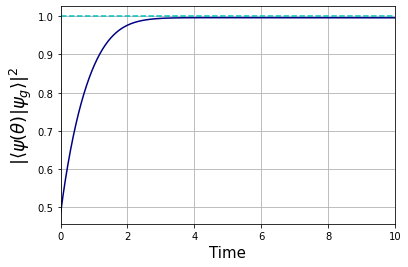

In [48]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

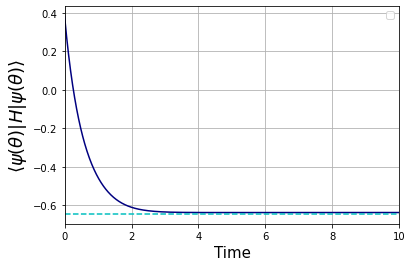

In [49]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

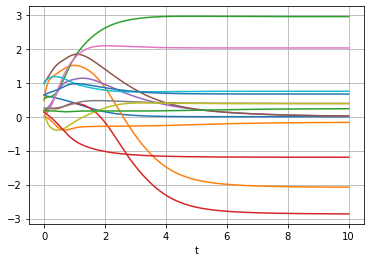

In [27]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [28]:
for i in range(coeff*N):
    print(Y[-1][i])

-0.0009822630236511927
-2.0773526708935393
2.9480469499510007
-2.864729471160893
0.018013947434421584
0.018293766962629833
2.024719767673083
0.39156328242486227
0.38360063620482215
0.7497325366621957
0.6668533985677328
-0.1685353591678328
0.23401062171479337
-1.1941919452995613


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

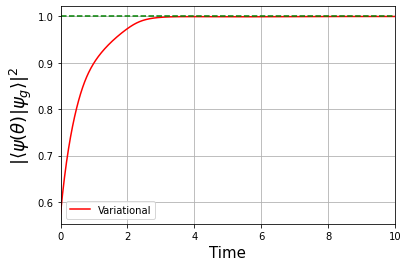

(0.0, 10.0)

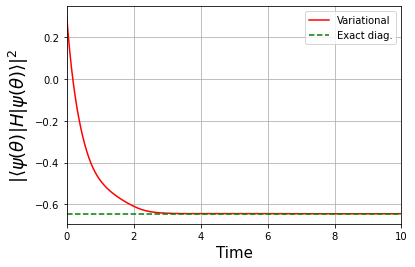

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
